In [26]:
#import Libraries and Load Data
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import joblib


#Define the path to the data file
file_path = r"C:\Data_Analyst_Power_BI\Customer_Churn_Analysis_project\Data & Resources\Data\Prediction_data.xlsx"

#Define the sheet name to read data from
sheet_name = "vw_ChurnData"

#Read the data from the specified sheet into a pandas Dataframe
data = pd.read_excel(file_path, sheet_name= sheet_name)

#Display the first few rows of the fetched data
print(data.head())



  Customer_ID  Gender  Age Married           State  Number_of_Referrals  \
0   55556-TAM  Female   45     Yes      Tamil Nadu                   13   
1   55568-MAD  Female   49      No  Madhya Pradesh                    0   
2   55601-MAD    Male   30     Yes  Madhya Pradesh                    7   
3   55609-BIH  Female   36      No           Bihar                   10   
4   55615-UTT  Female   45     Yes   Uttar Pradesh                   15   

   Tenure_in_Months Value_Deal Phone_Service Multiple_Lines  ...  \
0                30        NaN           Yes            Yes  ...   
1                15     Deal 5            No             No  ...   
2                11     Deal 4           Yes             No  ...   
3                29     Deal 2           Yes             No  ...   
4                33        NaN           Yes             No  ...   

    Payment_Method Monthly_Charge Total_Charges Total_Refunds  \
0  Bank Withdrawal      25.500000   1821.800049         16.85   
1  Bank Wi

In [27]:
#Data Processing
#Drop columns that won't be used for prediction
data = data.drop(['Customer_ID', 'Churn_Category','Churn_Reason'], axis=1)

#List of columns to be encoded

columns_to_encode = [
    'Gender', 'Married', 'State', 'Value_Deal', 'Phone_Service', 'Multiple_Lines', 'Internet_Service', 'Internet_Type', 
    'Online_Security','Online_Backup', 'Device_Protection_Plan', 'Premium_Support', 'Streaming_TV', 'Streaming_Movies', 'Streaming_Music',
    'Unlimited_Data', 'Contract', 'Paperless_Billing', 'Payment_Method'
]

#Encode Categorical variables except the target variables
label_encoders = {}
for column in columns_to_encode:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])
    

#Manually encode the target variable 'Customer_Status'
data['Customer_Status'] = data['Customer_Status'].map({'Stayed': 0, 'Churned':1})

# Separate the two classes
churned = data[data['Customer_Status'] == 1]
stayed = data[data['Customer_Status'] == 0]

# Oversample churned to match stayed
churned_oversampled = churned.sample(len(stayed), replace=True, random_state=42)

# Combine the oversampled churned with stayed
balanced_data = pd.concat([stayed, churned_oversampled])

# Shuffle the data
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Split features and target
X = balanced_data.drop('Customer_Status', axis=1)
y = balanced_data['Customer_Status']


In [28]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [29]:
from xgboost import XGBClassifier
# Calculate class imbalance ratio
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

# Initialize and train XGBoost model
xgb_model = XGBClassifier(scale_pos_weight=scale_pos_weight,
                          use_label_encoder=False,
                          eval_metric='logloss',
                          random_state=42)

xgb_model.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test)

# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

C:\Users\user\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:54:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Confusion Matrix:
[[777  91]
 [ 47 795]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       868
           1       0.90      0.94      0.92       842

    accuracy                           0.92      1710
   macro avg       0.92      0.92      0.92      1710
weighted avg       0.92      0.92      0.92      1710



In [30]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200],
    'scale_pos_weight': [scale_pos_weight]
}

grid = GridSearchCV(XGBClassifier(eval_metric='logloss', random_state=42), params, scoring='recall', cv=3)
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)

Best parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'scale_pos_weight': np.float64(0.9924264491698224)}


In [31]:
best_xgb = XGBClassifier(
    learning_rate=0.2,
    max_depth=7,
    n_estimators=100,
    scale_pos_weight=0.9924264491698224,
    eval_metric='logloss',
    random_state=42
)

best_xgb.fit(X_train, y_train)

# Predict on test set
y_pred_best = best_xgb.predict(X_test)

In [32]:
# Evaluate performance
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))

Confusion Matrix:
[[783  85]
 [ 45 797]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.90      0.92       868
           1       0.90      0.95      0.92       842

    accuracy                           0.92      1710
   macro avg       0.92      0.92      0.92      1710
weighted avg       0.92      0.92      0.92      1710



In [33]:
# Define the path to the Joiner Data Excel file
file_path = r"C:\Data_Analyst_Power_BI\Customer_Churn_Analysis_project\Data & Resources\Data\Prediction_data.xlsx"
sheet_name = 'vw_JoinData'

# Read the new data from the Excel sheet
new_data = pd.read_excel(file_path, sheet_name=sheet_name)

# Display the first few rows of the fetched data
print(new_data.head())

# Retain the original DataFrame to preserve unencoded columns
original_data = new_data.copy()

# Retain the Customer_ID column for tracking
customer_ids = new_data['Customer_ID']

# Drop columns not used for prediction
new_data = new_data.drop(['Customer_ID', 'Customer_Status', 'Churn_Category', 'Churn_Reason'], axis=1)

# Encode categorical variables using the saved label encoders
for column in new_data.select_dtypes(include=['object']).columns:
    new_data[column] = label_encoders[column].transform(new_data[column])

# Use the tuned XGBoost model instead of Random Forest
new_predictions = best_xgb.predict(new_data)

# Add predictions to the original DataFrame
original_data['Customer_Status_Predicted'] = new_predictions

# Filter the DataFrame to include only customers predicted as "Churned"
original_data = original_data[original_data['Customer_Status_Predicted'] == 1]

# Save the results to a CSV file
original_data.to_csv(r"C:\Data_Analyst_Power_BI\Customer_Churn_Analysis_project\Data & Resources\Data\Prediction.csv", index=False)


  Customer_ID  Gender  Age Married           State  Number_of_Referrals  \
0   57457-MAD  Female   46      No  Madhya Pradesh                   14   
1   58577-ODI  Female   44     Yes          Odisha                    7   
2   61025-MAH  Female   45      No     Maharashtra                    4   
3   61331-UTT    Male   36     Yes     Uttarakhand                    2   
4   61474-TEL    Male   52     Yes       Telangana                   11   

   Tenure_in_Months Value_Deal Phone_Service Multiple_Lines  ...  \
0                34        NaN           Yes             No  ...   
1                36     Deal 5           Yes             No  ...   
2                16     Deal 5           Yes             No  ...   
3                10     Deal 5           Yes             No  ...   
4                17        NaN           Yes             No  ...   

    Payment_Method Monthly_Charge Total_Charges Total_Refunds  \
0     Mailed Check      20.000000     38.000000           0.0   
1      Cre

In [34]:
# Load and preserve full joiner data
file_path = r"C:\Data_Analyst_Power_BI\Customer_Churn_Analysis_project\Data & Resources\Data\Prediction_data.xlsx"
sheet_name = 'vw_JoinData'
original_data = pd.read_excel(file_path, sheet_name=sheet_name)

# Copy to avoid modifying original
new_data = original_data.copy()

In [35]:
# Drop columns not needed for prediction
new_data = new_data.drop(['Customer_Status', 'Churn_Category', 'Churn_Reason', 'Customer_ID'], axis=1, errors='ignore')


In [36]:
# Encode with saved label encoders
for column in new_data.select_dtypes(include='object').columns:
    if column in label_encoders:
        new_data[column] = label_encoders[column].transform(new_data[column])


In [37]:
# Predict churn probability
y_proba = best_xgb.predict_proba(new_data)[:, 1]  # 411 values expected


In [38]:
# Do not filter original_data; keep all 411 rows
result_df = original_data.copy()
result_df['Churn_Probability'] = y_proba
result_df['Customer_Status_Predicted'] = (y_proba > 0.75).astype(int)


In [39]:
# 4. Save to file
result_df.to_csv("C:\Data_Analyst_Power_BI\Customer_Churn_Analysis_project\Data & Resources\Data\Customer_Churn_Predictions.csv", index=False)

In [40]:
print(len(result_df), len(y_proba))  # Both must be 411

411 411


In [41]:
print(result_df['Customer_Status_Predicted'].value_counts())


Customer_Status_Predicted
1    364
0     47
Name: count, dtype: int64


In [42]:
thresholds = [0.6, 0.7, 0.75, 0.8]
for t in thresholds:
    churn_count = (result_df['Churn_Probability'] > t).sum()
    print(f"Threshold {t}: Predicted churners = {churn_count}")

Threshold 0.6: Predicted churners = 369
Threshold 0.7: Predicted churners = 365
Threshold 0.75: Predicted churners = 364
Threshold 0.8: Predicted churners = 362


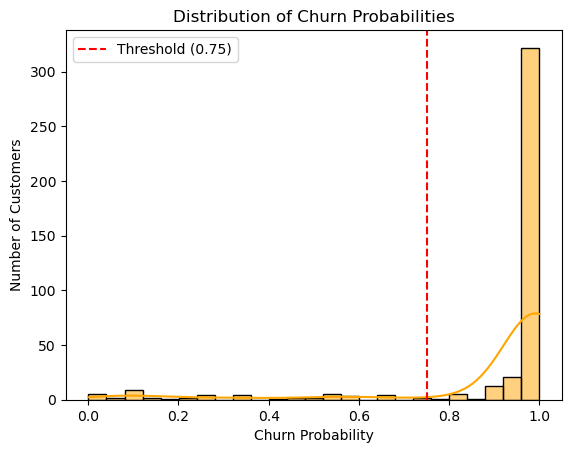

In [43]:

sns.histplot(result_df['Churn_Probability'], bins=25, kde=True, color='orange')
plt.axvline(0.75, color='red', linestyle='--', label='Threshold (0.75)')
plt.title("Distribution of Churn Probabilities")
plt.xlabel("Churn Probability")
plt.ylabel("Number of Customers")
plt.legend()
plt.show()


In [44]:
def risk_level(prob):
    if prob >= 0.9:
        return 'High Risk'
    elif prob >= 0.75:
        return 'Medium Risk'
    else:
        return 'Low Risk'

result_df['Risk_Level'] = result_df['Churn_Probability'].apply(risk_level)
print(result_df['Risk_Level'].value_counts())


Risk_Level
High Risk      351
Low Risk        47
Medium Risk     13
Name: count, dtype: int64


In [45]:
result_df.to_csv(r"C:\Data_Analyst_Power_BI\Customer_Churn_Analysis_project\Data & Resources\Data\Joiners_Churn_Risk_Segmented1.csv", index=False)

In [46]:
# Save the results to a CSV file
original_data.to_csv(r"C:\Data_Analyst_Power_BI\Customer_Churn_Analysis_project\Data & Resources\Data\Prediction.csv", index=False)


In [47]:
# Step 1: Predict churn probability
y_proba1 = best_xgb.predict_proba(new_data)[:, 1]

# Step 2: Attach to original data
result_df = original_data.copy()
result_df['Churn_Probability'] = y_proba1
result_df['Customer_Status_Predicted'] = (y_proba1 > 0.75).astype(int)

# Step 3: Filter only predicted churners
churners_df = result_df[result_df['Customer_Status_Predicted'] == 1]

# Step 4: Save to CSV or Excel
churners_df.to_csv("C:\Data_Analyst_Power_BI\Customer_Churn_Analysis_project\Data & Resources\Data\Predicted_Churners.csv", index=False)  # or .to_excel(...)